# BMEN 509 Introduction to Biomedical Imaging and Applications
## Term Project - 3D Printed Anatomy: Implementation and Application of Mesh Tomography

Group 1 Team Members: 
- Elyse Poupart, UCID: 30063027
- Matthew Scott, UCID:30072311
- Tyler Yip, UCID:30062807
- Andrew Lattimer, UCID:30062064

Objective: The objective of this project is to produce accurate and detailed 3D models of bones using image data transformation and various digital image processing techniques learned in class. The process will involve an evaluation of the different techniques available and their respective advantages and disadvantages. This information will be documented and analyzed to inform the choice of the most appropriate method for the project.

Noise elimination will be an essential step in the processing stage as it will help to create a clean, continuous and accurate final model. The elimination of noise in the data will help to improve the overall quality and reliability of the model and reduce the chances of errors or inaccuracies.

The ultimate goal is to develop an efficient processing method that can generate high-quality 3D models that are accurate, reliable and suitable for medical applications. If time permits, the processed data will be used to create a physical model using the 3D printers available from the Schulich makerspace. This physical model will then be used as a reference for the iterative design process, helping to identify and improve any shortcomings in the data processing methodology.

The iterative design process will aim to refine the data processing methodology and improve the overall quality of the model. This will involve evaluating the physical product against the original data and identifying any limitations or areas for improvement. The goal is to continuously improve the model until it is of a high enough quality to be used for various applications, such as in medical research, surgical planning or in the design of prosthetics.


In [1]:
# Install dependencies
%pip install nibabel # Used to manipulate .nii files
%pip install numpy-stl 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import os
import nibabel as nib
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from stl import mesh

# Matplotlib configuration
%matplotlib inline

# Numpy configuration
np.set_printoptions(precision=2)

In [3]:
# Input file path setup
data_directory = os.path.join('.', 'data')
file_names = [
    '001-CT.nii', '002-CT.nii', '003-CT.nii'
]

# Verify input files are available on current working directory
for file_name in file_names:
    name = os.path.join(data_directory, file_name)
    if not os.path.isfile(name):
        os.sys.exit('Cannot find file {}. Please make sure you have downloaded the data'.format(name))
print('Found all image files!')

Found all image files!


### Step 1: Data Exploration

TODO: Fill in description of what is happening here

Based on our exploratory analysis of the image using ITK-Snap, we discovered that the bone in the x-dimension is visible in the slice range of x=10 to x=210.

In [33]:
# Load CT001
CT001 = nib.load(os.path.join(data_directory, file_names[0])).get_fdata()
print("The shape of CT001:", CT001.shape)

The shape of CT001: (215, 124, 452)


In [34]:
# Crop CT001 to the region in the x-plane where the bone is visible
CT001 = CT001[10:210,:,:]
print("The shape of CT001 after cropping to the bone regions:", CT001.shape)

The shape of CT001 after cropping to the bone regions: (200, 124, 452)


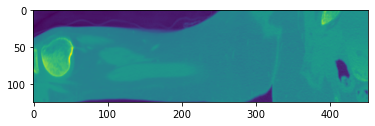

In [59]:
slice1 = CT001[20,:,:]
plt.imshow(slice1)
plt.show()

Text(0.5, 1.0, 'Slice xyz of CT Scan')

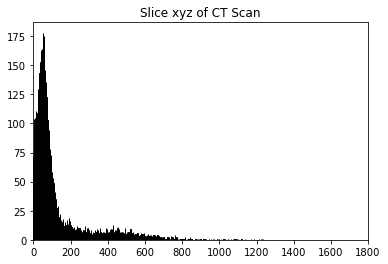

In [60]:
# This uses numpy to generate a histogram
hist,bins = np.histogram(slice1.flatten(),1800,[0,1800])

# And we plot the histogram here for the original 12 bit image
plt.hist(slice1.flatten(), 1800, [0,1800], fc='k', ec='k')
plt.xlim([0,1800])
plt.title('Slice xyz of CT Scan')

Text(0.5, 1.0, 'Segmented Mask')

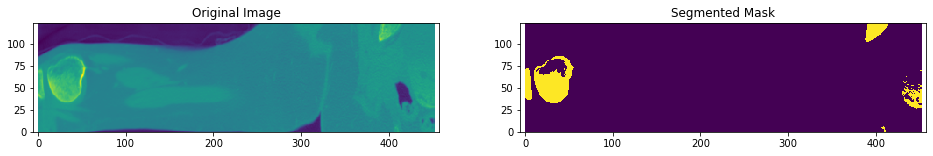

In [61]:
Threshold = 200

mask = np.zeros_like(slice1,'uint8')
mask[slice1 <= Threshold] = 0          
mask[slice1 > Threshold] = 1

plt.figure(figsize=(16, 2))
plt.subplot(121)
plt.pcolormesh(np.flipud(slice1))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

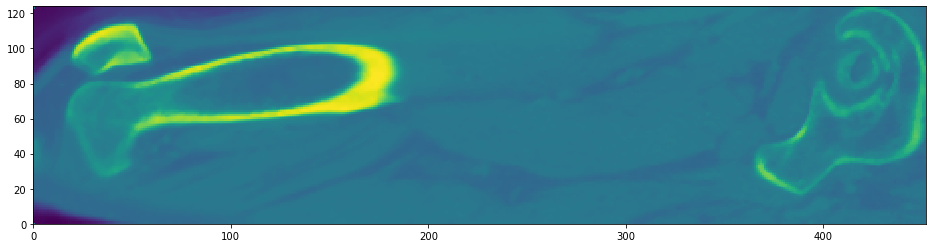

In [47]:
# Low Pass Filter - Median
from scipy.signal import medfilt

ImageF2=medfilt(slice1,3)

plt.figure(figsize=(16, 4))
plt.pcolormesh(np.flipud(ImageF2[:,:]))

Text(0.5, 1.0, 'Segmented Mask')

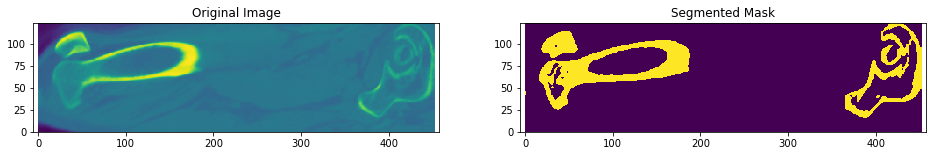

In [55]:
Threshold = 200

mask = np.zeros_like(slice1,'uint8')
mask[ImageF2[:,:] <= Threshold] = 0          
mask[ImageF2[:,:] > Threshold] = 1

plt.figure(figsize=(16, 2))
plt.subplot(121)
plt.pcolormesh(np.flipud(ImageF2[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

Text(0.5, 1.0, 'Slice xyz - Sobel Filtered')

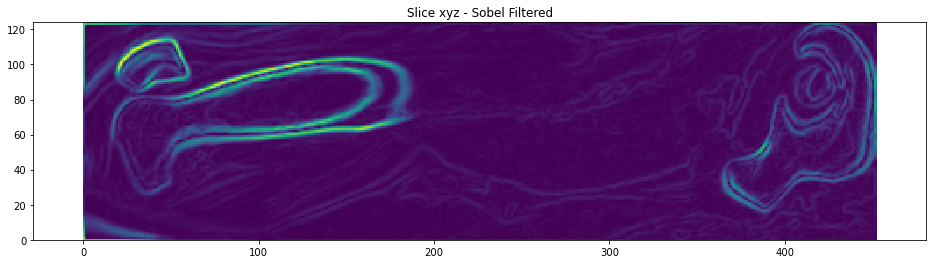

In [49]:
#High Pass Filter - Sobel

from scipy import ndimage

ImageSobelFx=ndimage.sobel(ImageF2,axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(ImageF2,axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)

#Plot filtered image
plt.figure(figsize=(16, 4))
plt.pcolormesh(np.flipud(ImageSobelF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Slice xyz - Sobel Filtered')

Text(0.5, 1.0, 'Segmented Mask')

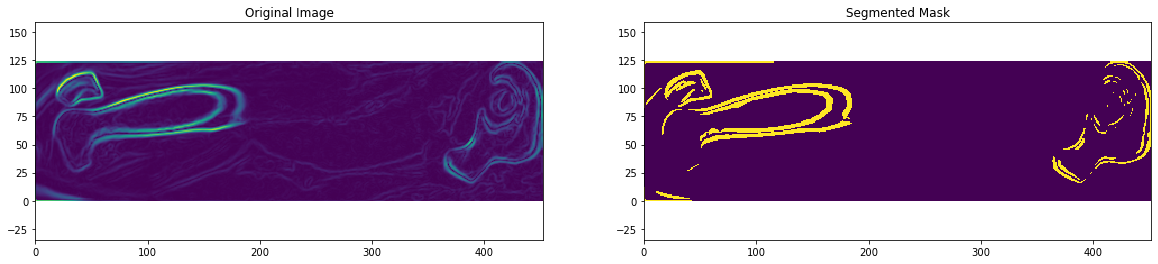

In [53]:
Threshold = 1200

mask = np.zeros_like(slice1,'uint8')
mask[ImageSobelF[:,:] <= Threshold] = 0          
mask[ImageSobelF[:,:] > Threshold] = 1

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.pcolormesh(np.flipud(ImageSobelF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

### Step 2: Segmentation

TODO: Fill in description of what is happening here

1. Loop through each slice
2. Apply the median filter
3. Segment based on a threshold
4. Combine the segmented slices back into a single image

In [63]:
# Define a function to perform the filtering and segmentation for each slice
def segment_slice(slice, kernel_size, threshold):
    # Filter the slice using the median filter
    filtered_slice = medfilt(slice, kernel_size)

    # Segment the filtered slice
    slice_segment = np.zeros_like(filtered_slice,'uint8')
    slice_segment[slice[:,:] <= threshold] = 0          
    slice_segment[slice[:,:] > threshold] = 1

    return slice_segment

In [65]:
# Use the segment_slice() function to segment the entire 3D image (volumetric segmentation)

segmentation = np.zeros_like(CT001,'uint8')

for slice_idx in range(0, 200):
    segmentation[slice_idx,:,:] = segment_slice(CT001[slice_idx,:,:], 3, 200)

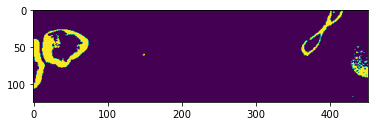

In [66]:
plt.imshow(segmentation[50,:,:])
plt.show()

### Step 3: Mesh Generation

TODO: Fill in description of what is happening here

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact_manual, interact

def make_mesh(image, threshold=5, step_size=1):
    p=image
    # generation of the vertices and faces of polygons using marching cubes
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

ImageforVolumeRendering=SegmentedArrayDicom3D[:,::4,::4]

verts, faces = make_mesh(ImageforVolumeRendering, 350)   #calls function to create mesh
plt_3d(verts, faces, 30,60);   #calls function to plot and opens a pager with execution information